In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
def c_get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return S @ linalg.funm(inv_S @ H, 
                    lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

def gc_get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return S @ linalg.funm(inv_S @ H,
                lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

def propagate_each(class_list, final_beta):
    for _ in class_list:
        _.propagate(final_beta, _.single_step_rk2)
        
def plot_eigs(class_list, ferm_exact, E, S, filename):
    plt.plot(E, linalg.eigvalsh(ferm_exact, S)[::-1], 'ks-', label='Exact')
    for _ in class_list:
        plt.plot(E, linalg.eigvalsh(_.rho, S)[::-1], label='tol=' + str(_.tol))
    plt.legend(numpoints=1)
    plt.savefig(filename, format='png', dpi=300)
    
def get_norm_diffs(class_list, ferm_exact):
    return [(_.tol, linalg.norm(ferm_exact - _.rho) / linalg.norm(ferm_exact))
            for _ in class_list]
    

In [3]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Define path for matrices
matrices_path = "larger_matrices/"

# 250 atom supercell

In [5]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 3 * 250
dbeta = 0.12

# Define tolerances to use
tols = [1e-7, 1e-6, 1e-5, 1e-4]

In [6]:
# Define betas with temperatures
kb = 3.1668114 * 10**(-6)
temps = [500000, 100000, 50000, 20000, 10000, 5000, 3000, 2000, 1000]
betas = [1/(x * kb) for x in temps]

## Canonical

In [28]:
# Create classes for each tolerance
c_250_list = [CAdaptive_C_RK4_sqrt(ovlp=S_250, H=H_250, 
                                   num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-2, tol=_) for _ in tols]

In [29]:
# Propagate to each beta and record the number of non-zeros for each tolerance
rho_eigs_list = []
sparsity_list = []
for c in c_250_list:
    # Create list for storing sparsity of a given tolerance at each beta
    sparsity_for_tol = []
    rho_eigs_for_tol = []
    for b in betas:
        c.propagate(b, c.single_step_rk2)
        sparsity_for_tol.append(c.sparsity)
        rho_eigs_for_tol.append(linalg.eigvalsh(c.rho, S_250))
    
    # Append list to bigger list and then move onto next tolerance value
    sparsity_list.append(sparsity_for_tol)
    rho_eigs_list.append(rho_eigs_for_tol)
        

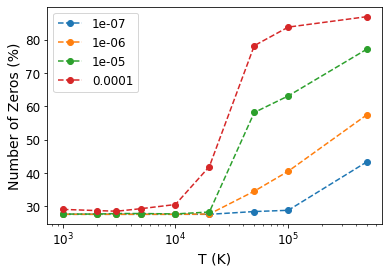

In [32]:
ax = plt.subplot()
for i in range(len(sparsity_list)):
    ax.plot(temps, np.array(sparsity_list[i])*100, 'o--', label=str(tols[i]))
ax.set_xlabel("T (K)")
ax.set_xscale("log")
ax.set_ylabel("Number of Zeros (%)")
ax.legend(numpoints=1)
plt.savefig("larger_matrices/sqrt_figs/C/sparsity.png", format='png', dpi=300)

In [10]:
def funm_herm(a, func):
    w, v = linalg.eigh(a)
    w = func(w)
    return (v * w).dot(v.conj().T)

isq = funm_herm(S_250, lambda x: -1/np.sqrt(x))
Ho = isq @ H_250 @ isq

In [11]:
w, v = linalg.eigh(Ho)
nel = 3 * 250
mu = w[int(nel/2)-1] + 0.5*(w[int(nel/2)] - w[int(nel/2)-1])
print("Chemical Potential:", 27.2114 * mu, " eV")

Chemical Potential: -2.827416015360111  eV


In [12]:
nz = {}
for b in betas:
    print(b)
    nz[b] = {}
    we = [1.0/(1 + np.exp(b*(x - mu))) for x in w]
    P = v.dot(np.diag(we)).dot(v.T)
    for t in tols:
        nz[b][t] = 0
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                if abs(P[i, j]) < t:
                    nz[b][t] += 1

0.6315500822057165
3.1577504110285823
6.315500822057165
15.788752055142913
31.577504110285826
63.15500822057165
105.25834703428607
157.88752055142913
315.77504110285827


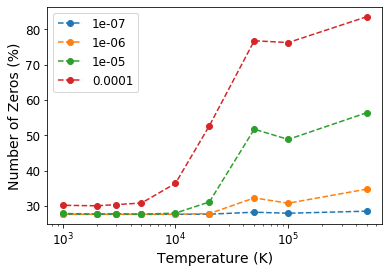

In [23]:
fig, axs = plt.subplots()
for t in tols:
    axs.plot(temps, [nz[b][t]/(P.shape[0]**2) * 100 for b in betas], 'o--', label=str(t))
axs.set_ylabel("Number of Zeros (%)")
axs.set_xscale("log")
#axs.set_xlabel("Temperature (K)")
axs.legend()
pass

## Grand Canonical

In [19]:
# Define chemical potential
num_electrons = 3 * 250
core_spec = linalg.eigvalsh(H_250, S_250)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [20]:
gc_250_list = [CAdaptive_GC_RK4_sqrt(ovlp=S_250, H=H_250, mu=mu, dbeta=dbeta, 
                                 epsilon=1e-2, tol=_) for _ in tols]

In [21]:
# Propagate to each beta and record the number of non-zeros for each tolerance
gc_rho_eigs_list = []
gc_sparsity_list = []
for gc in gc_250_list:
    # Create list for storing sparsity of a given tolerance at each beta
    gc_sparsity_for_tol = []
    gc_rho_eigs_for_tol = []
    for b in betas:
        gc.propagate(b, gc.single_step_rk2)
        gc_sparsity_for_tol.append(gc.sparsity)
        gc_rho_eigs_for_tol.append(linalg.eigvalsh(gc.rho, S_250))
    
    # Append list to bigger list and then move onto next tolerance value
    gc_sparsity_list.append(gc_sparsity_for_tol)
    gc_rho_eigs_list.append(gc_rho_eigs_for_tol)

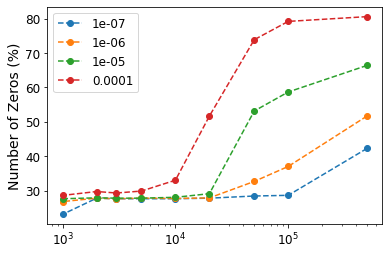

In [31]:
ax = plt.subplot()
for i in range(len(gc_sparsity_list)):
    ax.plot(temps, np.array(gc_sparsity_list[i])*100, 'o--', label=str(tols[i]))
#ax.set_xlabel("T (K)")
ax.set_xscale("log")
ax.set_ylabel("Number of Zeros (%)")
ax.legend(numpoints=1)
plt.savefig("larger_matrices/sqrt_figs/GC/sparsity.png", format='png', dpi=300)

In [16]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

num_electrons = 3 * 16

c_16_list = [CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, 
                                   num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-2, tol=_) for _ in tols]

In [17]:
# Propagate to each beta and record the number of non-zeros for each tolerance
rho_eigs_list = []
sparsity_list = []
for c in c_16_list:
    # Create list for storing sparsity of a given tolerance at each beta
    sparsity_for_tol = []
    rho_eigs_for_tol = []
    for b in betas:
        c.propagate(b, c.single_step_rk2)
        sparsity_for_tol.append(c.sparsity)
        rho_eigs_for_tol.append(linalg.eigvalsh(c.rho, S_16))
    
    # Append list to bigger list and then move onto next tolerance value
    sparsity_list.append(sparsity_for_tol)
    rho_eigs_list.append(rho_eigs_for_tol)
        

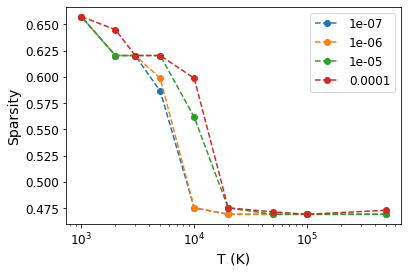

In [18]:
ax = plt.subplot()
for i in range(len(sparsity_list)):
    ax.plot(temps, sparsity_list[i], 'o--', label=str(tols[i]))
ax.set_xlabel("T (K)")
ax.set_xscale("log")
ax.set_ylabel("Sparsity")
ax.legend(numpoints=1)
plt.savefig("larger_matrices/sqrt_figs/C/16_sparsity.png", format='png', dpi=300)